# Pfpr Validation for Burkina Faso 


In [53]:
import os
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from rasterio.plot import show

### Helper Functions

In [54]:
def load_data(file_path, metric="pfpr2to10", year="2022"):
    conn = sqlite3.connect(file_path)
    monthlydata = pd.read_sql_query("SELECT * FROM monthlydata;", conn)
    monthlysitedata = pd.read_sql_query("SELECT * FROM monthlysitedata;", conn)
    merged_data = pd.merge(monthlysitedata, monthlydata, left_on="monthlydataid", right_on="id")
    merged_data["datetime"] = pd.to_datetime(merged_data["modeltime"], unit="s")
    data = merged_data[["datetime", "locationid", metric, "population"]]
    mask_year = (data["datetime"] >= year + "-01-01") & (data["datetime"] <= year + "-12-31")
    data_year = data[(mask_year)]
    return data_year

In [55]:
def read_raster_data(folder, filename):
    raster_data = {}
    coordinates_to_location_map = {}
    nodata_value = -9999
    path = os.path.join(folder, filename)
    location_id = 0
    with open(path, "r") as f:
        # Read header lines
        metadata = {}
        for _ in range(6):
            key, value = next(f).strip().split()
            metadata[key] = value

        row = 0
        for line in f:
            col = 0
            for value in line.split():
                value = float(value)

                if value != nodata_value:
                    raster_data[location_id] = value
                    coordinates_to_location_map[(row, col)] = location_id
                    location_id += 1
                col += 1
            row += 1

    return metadata, coordinates_to_location_map, raster_data

In [56]:
def write_raster_data(df, metric, metadata, coordinates_to_location_map, output_filename):
    location_to_metric_map = df.set_index("locationid")[metric].to_dict()
    # Extract metadata values
    ncols = int(metadata["ncols"])
    nrows = int(metadata["nrows"])
    nodata_value = float(metadata["NODATA_value"])

    new_raster = np.full((nrows, ncols), nodata_value, dtype=float)

    for row in range(nrows):
        for col in range(ncols):
            if (row, col) in coordinates_to_location_map:
                location_id = coordinates_to_location_map[(row, col)]
                new_raster[row, col] = location_to_metric_map[location_id]

    # output_filename = metric+"_predicted.asc"
    try:
        with open(output_filename, "w") as f:
            for key, value in metadata.items():
                f.write(key + " " * (14 - (len(key))) + value + "\n")

            for row in new_raster:
                f.write(" ".join(map(str, row)) + "\n")

        print(f"Raster data written to {output_filename}")
    except Exception as e:
        print(f"Error writing raster data to {output_filename}: {e}")

    return output_filename

In [57]:
def plot_heatmap_from_asc(file_path, ax=None):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        data = np.where(data == src.nodata, np.nan, data)

        if ax is None:
            fig, ax = plt.subplots()

        im = ax.imshow(data, cmap="viridis", aspect="auto")
        ax.set_title(f"Heatmap from raster file: {file_path}")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        plt.colorbar(im, ax=ax, label="Value")
        if ax is None:
            plt.show()  # Show only if it's a standalone plot

### Districtwise validation

In [58]:
# district_db_file = "monthly_data_0.db"
# district_db_file = "monthly_data_3.db" # updated beta
# district_db_file = "monthly_data_5.db" # updated beta
# district_db_file = "monthly_data_7.db"
district_db_file = "monthly_data_9.db"
pfpr_data_district_2022 = load_data(district_db_file)
pfpr_data_district_2022[
    "pfpr2to10"
].mean()  # pfpr for the entire country (probably we need to weigh by population of location)

np.float64(22.16985377955147)

In [81]:
groped_df = pfpr_data_district_2022.groupby("locationid").mean()  # pfpr for each location

,datetime,pfpr2to10,population
locationid,,,
1,2022-06-16 12:00:00,20.499824,4.651076e+05
2,2022-06-16 12:00:00,21.819777,2.623129e+05
3,2022-06-16 12:00:00,17.202098,1.013445e+06
4,2022-06-16 12:00:00,20.647384,4.034256e+05
5,2022-06-16 12:00:00,22.169592,4.200514e+05
6,2022-06-16 12:00:00,27.483386,4.038752e+05
7,2022-06-16 12:00:00,24.522662,2.114013e+05
8,2022-06-16 12:00:00,24.587869,4.871394e+05
9,2022-06-16 12:00:00,21.567739,5.896778e+05


In [83]:
# Districtwise pfpr2to10
predicted_pfpr_district_df = (
    pfpr_data_district_2022.groupby("locationid").mean().reset_index()[["locationid", "pfpr2to10", "population"]]
)
print(predicted_pfpr_district_df.head())
weighted_mean_pfpr = (
    predicted_pfpr_district_df["pfpr2to10"] * predicted_pfpr_district_df["population"]
).sum() / predicted_pfpr_district_df["population"].sum()
print("weighted mean pfpr: ", weighted_mean_pfpr)

   locationid  pfpr2to10    population
0           1  20.499824  4.651076e+05
1           2  21.819777  2.623129e+05
2           3  17.202098  1.013445e+06
3           4  20.647384  4.034256e+05
4           5  22.169592  4.200514e+05
weighted mean pfpr:  21.48901071251261


In [60]:
# Districtwise predicted pfpr map, map is pixelwise , but all the pixels belonging to a district will get the same pfpr2to10 value

metadata, coordinates_to_location_map, districts = read_raster_data(".", "bfa_districts.asc")

coordinates_to_districts_map = {}
for coordinate, pixel_id in coordinates_to_location_map.items():
    coordinates_to_districts_map[coordinate] = districts[pixel_id]
# print(coordinates_to_districts_map)

predicted_pfpr_district_raster_filename = "predicted_pfpr_district_raster.asc"
write_raster_data(
    predicted_pfpr_district_df,
    "pfpr2to10",
    metadata,
    coordinates_to_districts_map,
    predicted_pfpr_district_raster_filename,
)

# plot_heatmap_from_asc(predicted_pfpr_district_raster_filename)

Raster data written to predicted_pfpr_district_raster.asc


'predicted_pfpr_district_raster.asc'

In [61]:
# Districtwise true pfpr map
bfa_subnational_df = pd.read_csv("bfa_subnational_2022.csv")
true_pfpr_district_df = bfa_subnational_df[(bfa_subnational_df.Metric == "Infection Prevalence")]
district_id_mapping_df = pd.read_csv("bfa_mapping.csv")
district_id_mapping = district_id_mapping_df.set_index("REGION_NAME")["ID"].to_dict()
true_pfpr_district_df["locationid"] = true_pfpr_district_df["Name"].map(district_id_mapping)

true_pfpr_district_df.rename(columns={"Value": "pfpr2to10"}, inplace=True)

true_pfpr_district_raster_filename = "true_pfpr_district_raster.asc"
write_raster_data(
    true_pfpr_district_df, "pfpr2to10", metadata, coordinates_to_districts_map, true_pfpr_district_raster_filename
)

# plot_heatmap_from_asc(true_pfpr_district_raster_filename)

Raster data written to true_pfpr_district_raster.asc


/tmp/ipykernel_464693/1178649840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pfpr_district_df["locationid"] = true_pfpr_district_df["Name"].map(district_id_mapping)
/tmp/ipykernel_464693/1178649840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pfpr_district_df.rename(columns={"Value" : "pfpr2to10"}, inplace=True)


'true_pfpr_district_raster.asc'

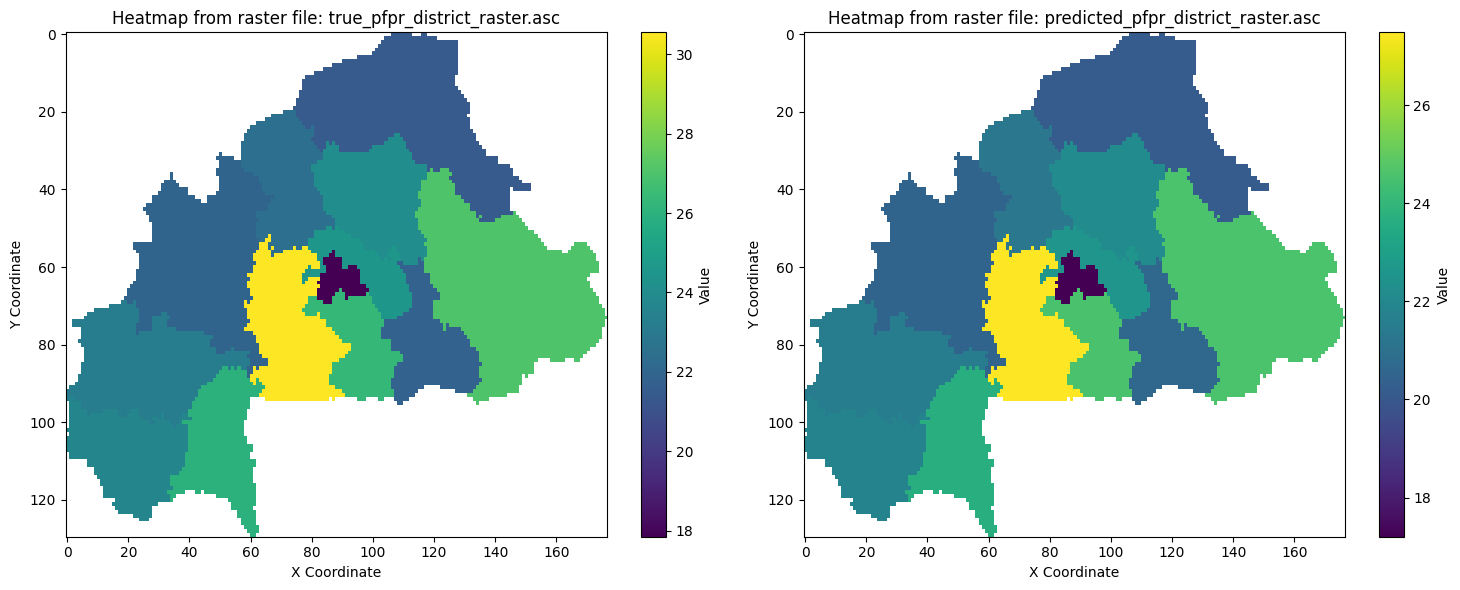

In [62]:
# Plotting true pfpr and predicted pfpr maps for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot first file
plot_heatmap_from_asc(true_pfpr_district_raster_filename, ax=axes[0])

# Plot second file
plot_heatmap_from_asc(predicted_pfpr_district_raster_filename, ax=axes[1])

# Show both plots
plt.tight_layout()
plt.show()

In [63]:
pfpr_district_comparison_df = pd.merge(
    true_pfpr_district_df[["Name", "locationid", "pfpr2to10"]],
    predicted_pfpr_district_df[["locationid", "pfpr2to10", "population"]],
    on="locationid",
)
pfpr_district_comparison_df["pfpr_diff"] = (
    pfpr_district_comparison_df["pfpr2to10_x"] - pfpr_district_comparison_df["pfpr2to10_y"]
)
pfpr_district_comparison_df

,Name,locationid,pfpr2to10_x,pfpr2to10_y,population,pfpr_diff
0,Centre-Ouest,6,30.556049,27.483386,4.038752e+05,3.072663
1,Sud-Ouest,13,26.033291,23.673092,2.189744e+05,2.360199
2,Sahel,12,21.502332,20.209098,3.750978e+05,1.293234
3,Centre,3,17.845419,17.202098,1.013445e+06,0.643320
4,Centre-Nord,5,24.096468,22.169592,4.200514e+05,1.926876
5,Centre-Est,4,21.847088,20.647384,4.034256e+05,1.199705
6,Plateau Central,11,24.552382,22.562587,2.265492e+05,1.989795
7,Cascades,2,23.626862,21.819777,2.623129e+05,1.807086
8,Est,8,27.073454,24.587869,4.871394e+05,2.485585
9,Nord,10,22.481468,21.262991,3.900652e+05,1.218477


Text(0.5, 1.0, 'True pfpr2to10 vs Predicted pfpr2to10 for Burkina Faso (Districtwise)')

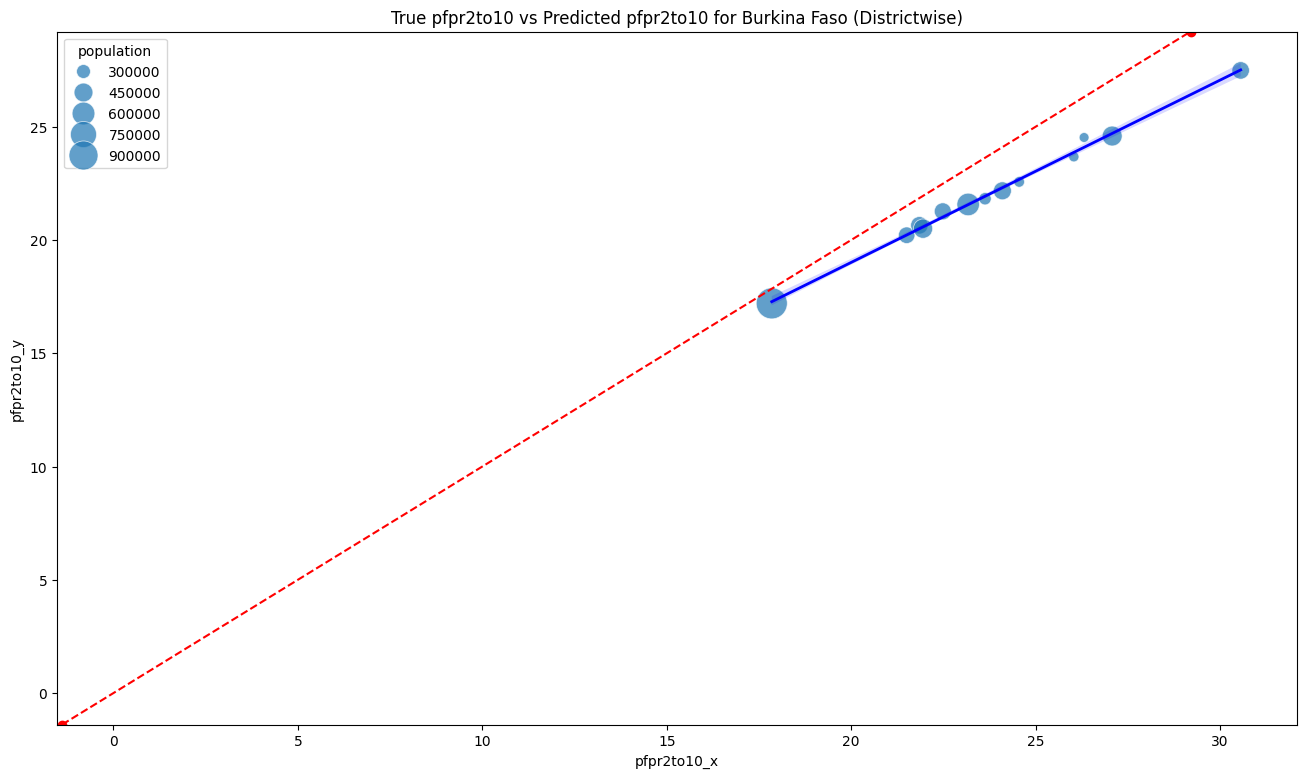

In [64]:
plt.figure(figsize=(16, 9))

ax = sns.scatterplot(
    data=pfpr_district_comparison_df, x="pfpr2to10_x", y="pfpr2to10_y", size="population", sizes=(50, 500), alpha=0.7
)
sns.regplot(
    data=pfpr_district_comparison_df,
    x="pfpr2to10_x",
    y="pfpr2to10_y",
    scatter=False,
    ax=ax,
    line_kws={"color": "blue", "linewidth": 2},
    scatter_kws={"alpha": 0.5},
)
ax.axline((0, 0), slope=1, marker="o", linestyle="dashed", color="red")
plt.title("True pfpr2to10 vs Predicted pfpr2to10 for Burkina Faso (Districtwise)")

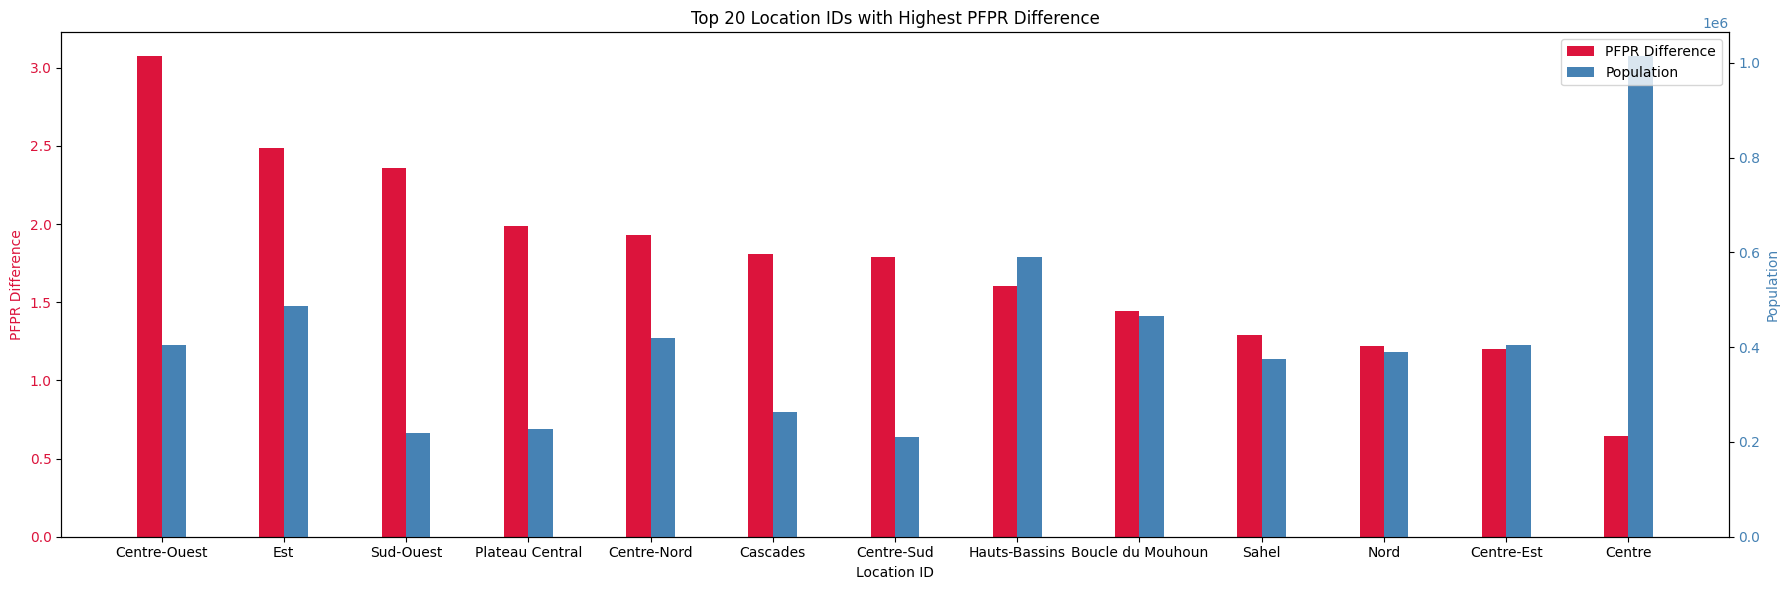

In [65]:
# Sort the dataframe by pfpr_diff in descending order and select top n
n = 20
top_n_error_df = pfpr_district_comparison_df.nlargest(n, "pfpr_diff")

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_n_error_df))
r2 = [x + bar_width for x in r1]

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot pfpr_diff on the primary y-axis
color = "crimson"
ax1.set_xlabel("Location ID")
ax1.set_ylabel("PFPR Difference", color=color)
ax1.bar(r1, np.abs(top_n_error_df["pfpr_diff"]), color=color, width=bar_width, label="PFPR Difference")
ax1.tick_params(axis="y", labelcolor=color)

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot population_x on the secondary y-axis
color = "steelblue"
ax2.set_ylabel("Population", color=color)
ax2.bar(r2, top_n_error_df["population"], color=color, width=bar_width, label="Population")
ax2.tick_params(axis="y", labelcolor=color)

# Add title and legend
plt.title(f"Top {n} Location IDs with Highest PFPR Difference")
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Set x-axis ticks and labels
plt.xticks([r + bar_width / 2 for r in range(len(top_n_error_df))], top_n_error_df["Name"].astype(str), rotation=90)
plt.show()

### Pixelwise validation

In [66]:
# pixel_db_file = "monthly_data_2.db" # calibration year 2022
# pixel_db_file = "monthly_data_4.db" # calibration year 2022, new beta
# pixel_db_file = "monthly_data_6.db" # calibration year 2022, new beta
# pixel_db_file = "monthly_data_8.db" #new calibration
pixel_db_file = "monthly_data_10.db"
pfpr_data_2022 = load_data(pixel_db_file)
pfpr_data_2022["pfpr2to10"].mean()

np.float64(22.75700946763503)

In [67]:
# Pixelwise pfpr2to10
predicted_pfpr_df = pfpr_data_2022.groupby("locationid").mean().reset_index()[["locationid", "pfpr2to10", "population"]]
predicted_pfpr_df

,locationid,pfpr2to10,population
0,0,22.222222,10.500000
1,1,2.285354,29.333333
2,2,20.039683,27.750000
3,3,10.366162,34.666667
4,4,19.103119,32.833333
...,...,...,...
11920,11920,51.194297,107.666667
11921,11921,49.965612,123.833333
11922,11922,44.545228,98.500000
11923,11923,35.546190,54.916667


In [68]:
# Pixelwise predicted pfpr map
metadata, coordinates_to_location_map, true_pfpr = read_raster_data(".", "bfa_pfpr2to10.asc")
_, _, population = read_raster_data(".", "bfa_initialpopulation.asc")
predicted_pfpr_df_scaled = predicted_pfpr_df.copy()
predicted_pfpr_df_scaled["pfpr2to10"] /= 100
predicted_pfpr_pixel_raster_filename = "predicted_pfpr_pixel_raster"
write_raster_data(
    predicted_pfpr_df_scaled, "pfpr2to10", metadata, coordinates_to_location_map, predicted_pfpr_pixel_raster_filename
)

Raster data written to predicted_pfpr_pixel_raster


'predicted_pfpr_pixel_raster'

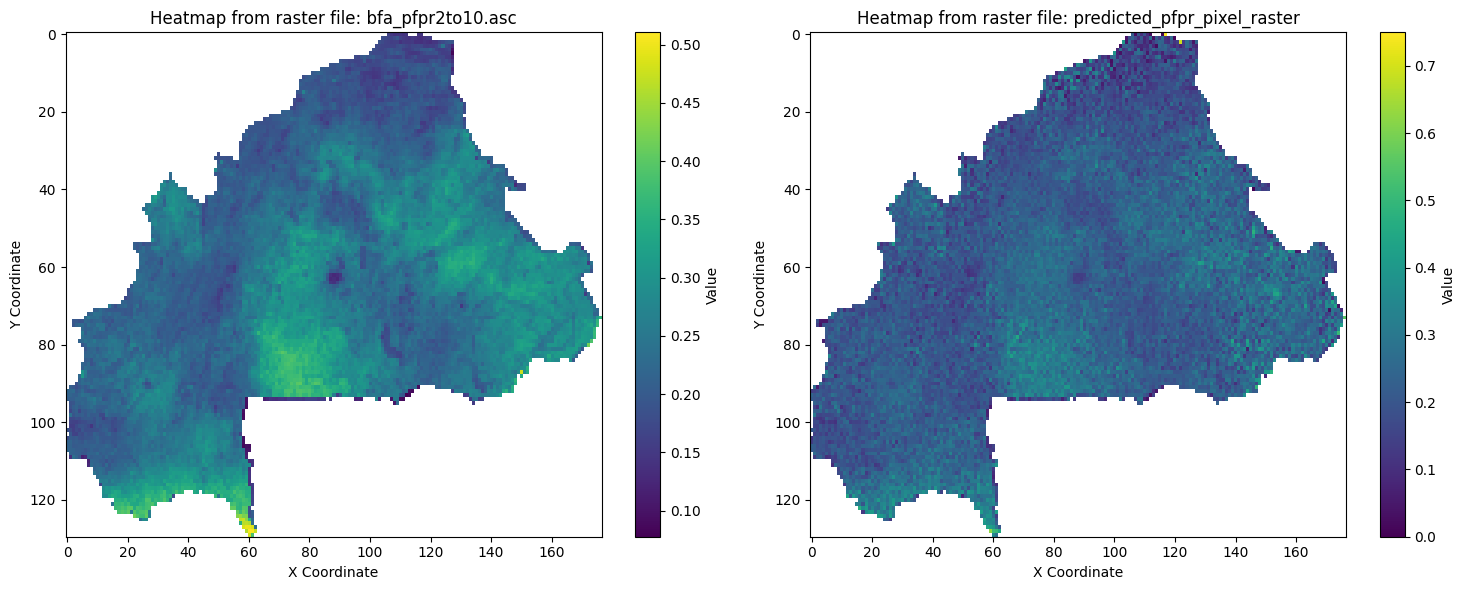

In [69]:
# Create subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot first file
plot_heatmap_from_asc("bfa_pfpr2to10.asc", ax=axes[0])

# Plot second file
plot_heatmap_from_asc(predicted_pfpr_pixel_raster_filename, ax=axes[1])

# Show both plots
plt.tight_layout()
plt.show()

In [70]:
locations = list(true_pfpr.keys())
true_pfpr_df = pd.DataFrame({"locationid": locations})
true_pfpr_df["pfpr2to10"] = true_pfpr_df["locationid"].map(true_pfpr)
true_pfpr_df["pfpr2to10"] = true_pfpr_df["pfpr2to10"] * 100
true_pfpr_df["population"] = true_pfpr_df["locationid"].map(population)


pfpr_comparison_df = pd.merge(true_pfpr_df, predicted_pfpr_df, on="locationid")
pfpr_comparison_df

,locationid,pfpr2to10_x,population_x,pfpr2to10_y,population_y
0,0,16.24021,34.0,22.222222,10.500000
1,1,14.89300,63.0,2.285354,29.333333
2,2,14.15368,76.0,20.039683,27.750000
3,3,14.30086,83.0,10.366162,34.666667
4,4,14.66886,72.0,19.103119,32.833333
...,...,...,...,...,...
11920,11920,51.06495,314.0,51.194297,107.666667
11921,11921,50.69214,367.0,49.965612,123.833333
11922,11922,47.21123,258.0,44.545228,98.500000
11923,11923,48.23237,167.0,35.546190,54.916667


Text(0.5, 1.0, 'True pfpr2to10 vs Predicted pfpr2to10 for Burkina Faso')

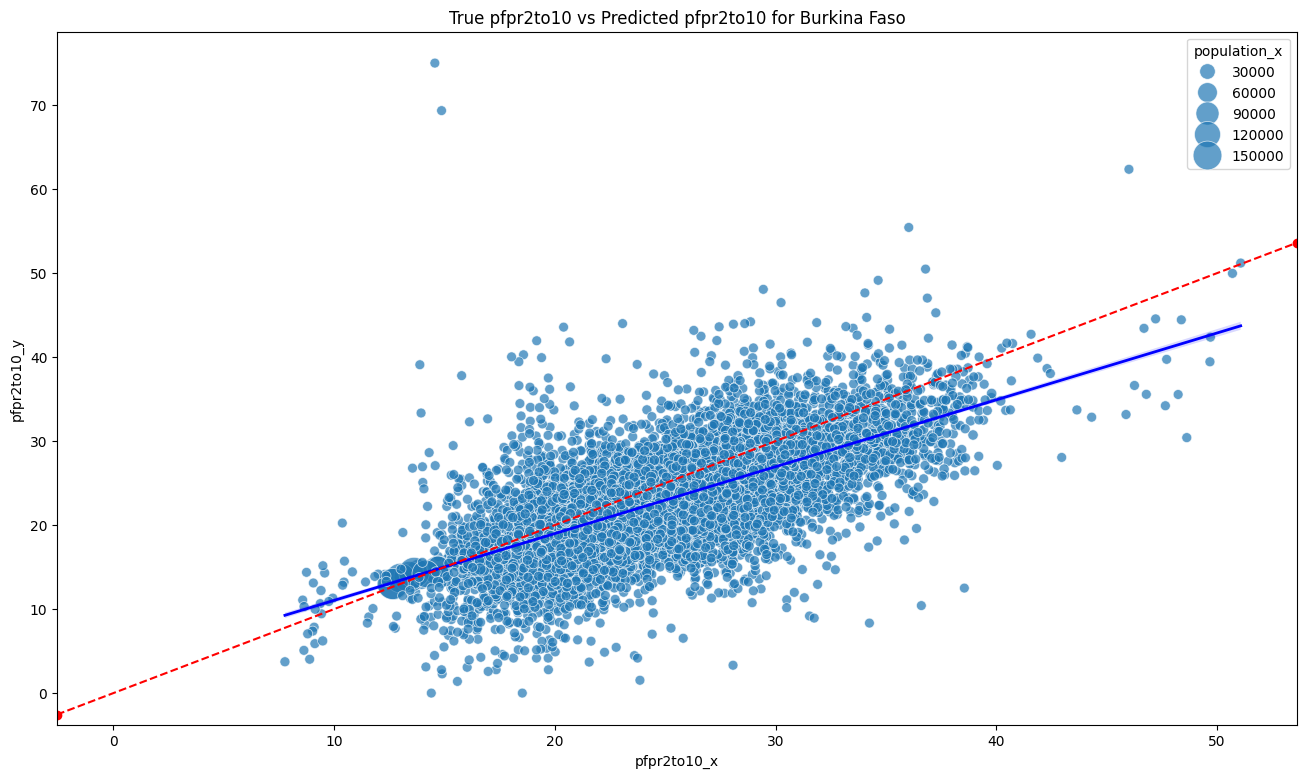

In [71]:
plt.figure(figsize=(16, 9))

ax = sns.scatterplot(
    data=pfpr_comparison_df, x="pfpr2to10_x", y="pfpr2to10_y", size="population_x", sizes=(50, 500), alpha=0.7
)
sns.regplot(
    data=pfpr_comparison_df,
    x="pfpr2to10_x",
    y="pfpr2to10_y",
    scatter=False,
    ax=ax,
    line_kws={"color": "blue", "linewidth": 2},
    scatter_kws={"alpha": 0.5},
)
ax.axline((0, 0), slope=1, marker="o", linestyle="dashed", color="red")
plt.title("True pfpr2to10 vs Predicted pfpr2to10 for Burkina Faso")

Text(0.24, 0.9, 'Burkina Faso True Prevalence vs Predicted Prevalence in 2022')

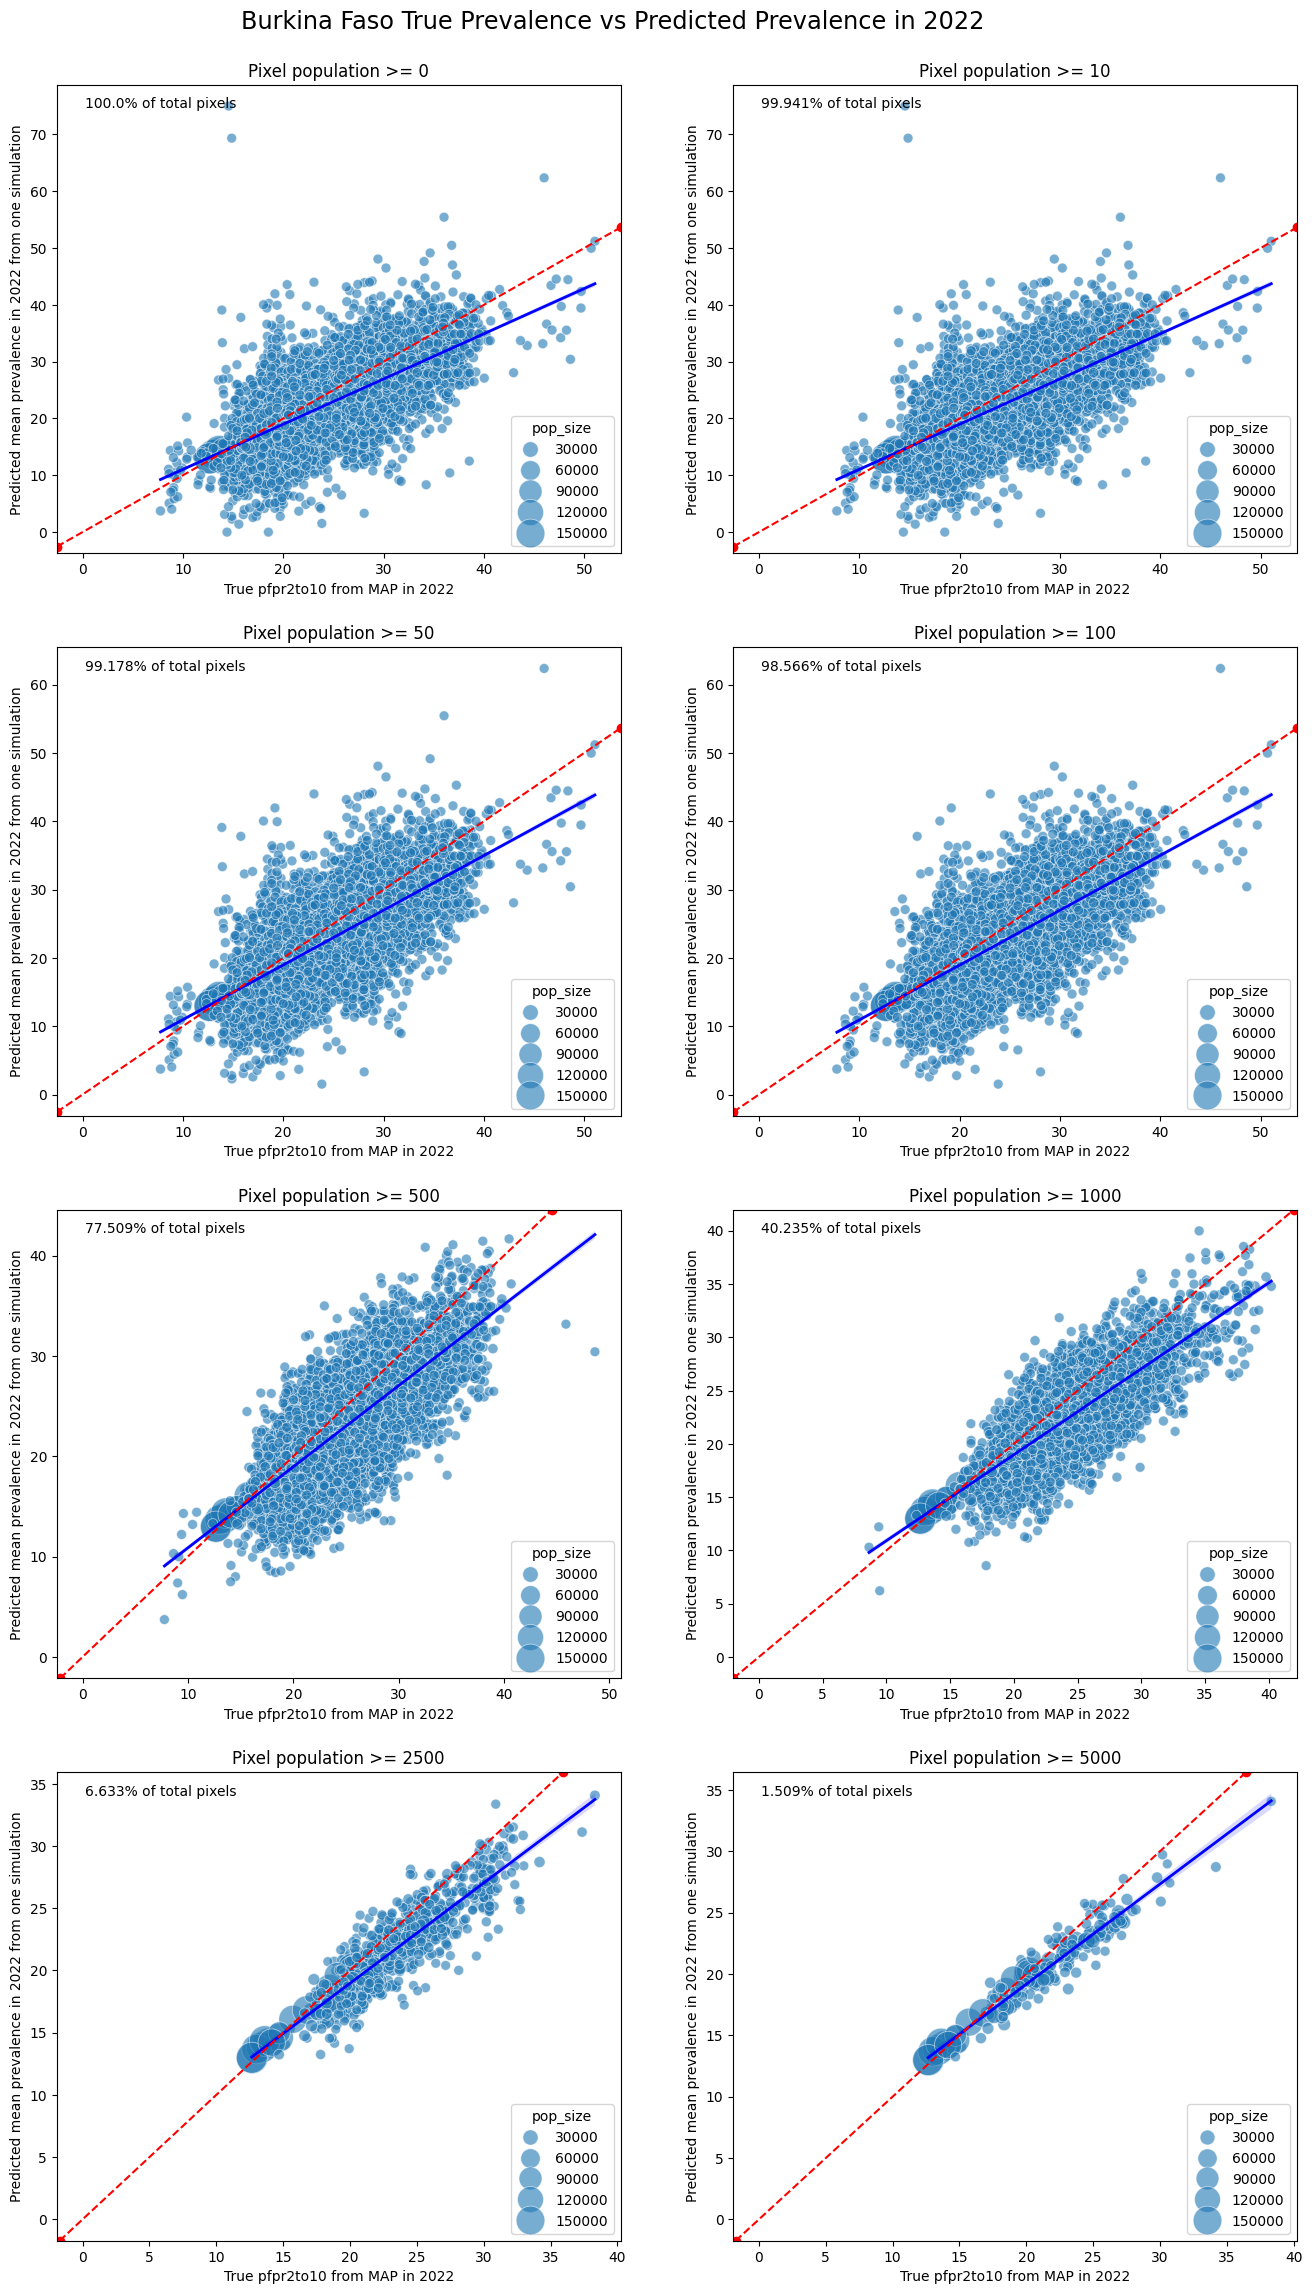

In [72]:
# Plot with sparsely populated pixels filtered out
plot_data = pfpr_comparison_df.rename(
    columns={
        "pfpr2to10_x": "True pfpr2to10 from MAP in 2022",
        "pfpr2to10_y": "Predicted mean prevalence in 2022 from one simulation",
        "population_x": "pop_size",
    }
)
nrows, ncols = 4, 2
fig = plt.figure(figsize=(2 * 8, 4 * 7))
for index, population in enumerate([0, 10, 50, 100, 500, 1000, 2500, 5000]):
    ax = fig.add_subplot(nrows, ncols, index + 1)
    df_pop_threshold = plot_data[plot_data.pop_size >= population]
    sns.scatterplot(
        data=df_pop_threshold,
        x="True pfpr2to10 from MAP in 2022",
        y="Predicted mean prevalence in 2022 from one simulation",
        size="pop_size",
        sizes=(50, 500),
        alpha=0.6,
    )
    sns.regplot(
        data=df_pop_threshold,
        x="True pfpr2to10 from MAP in 2022",
        y="Predicted mean prevalence in 2022 from one simulation",
        scatter=False,
        ax=ax,
        line_kws={"color": "blue", "linewidth": 2},
        scatter_kws={"alpha": 0.5},
    )
    ax.axline((0, 0), slope=1, marker="o", linestyle="dashed", color="red")
    text = f"{round(100 * len(df_pop_threshold) / len(plot_data), 3)}% of total pixels"
    ax.annotate(text, xy=(0.05, 0.95), xycoords="axes fraction")
    ax.set_title(f"Pixel population >= {population}")
fig.text(0.24, 0.9, "Burkina Faso True Prevalence vs Predicted Prevalence in 2022", fontsize="xx-large")
# plt.savefig(os.path.join('..', 'Plots', 'Prevalence_check.png'), bbox_inches='tight')

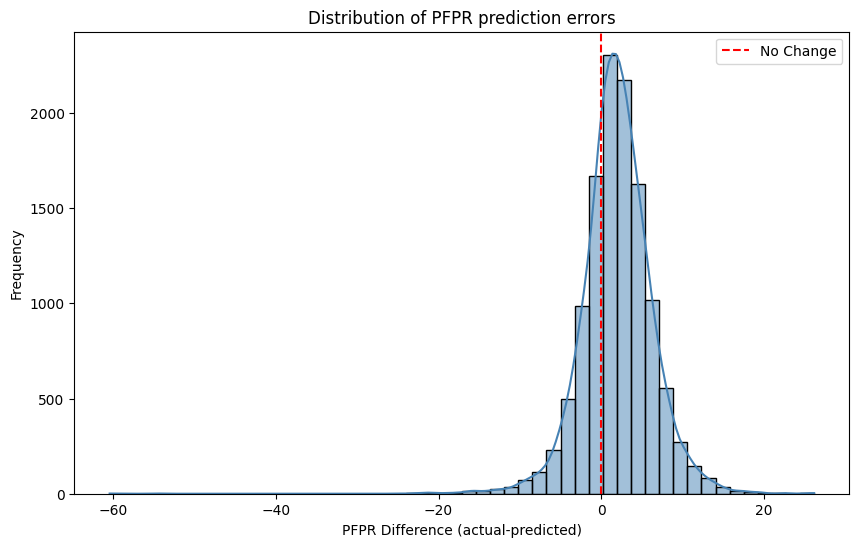

In [73]:
# Distribution of PFPR prediction errors
pfpr_comparison_df["pfpr_diff"] = pfpr_comparison_df["pfpr2to10_x"] - pfpr_comparison_df["pfpr2to10_y"]
pfpr_comparison_df

plt.figure(figsize=(10, 6))
sns.histplot(pfpr_comparison_df["pfpr_diff"], bins=50, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--", label="No Change")
plt.xlabel("PFPR Difference (actual-predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of PFPR prediction errors")
plt.legend()
plt.show()

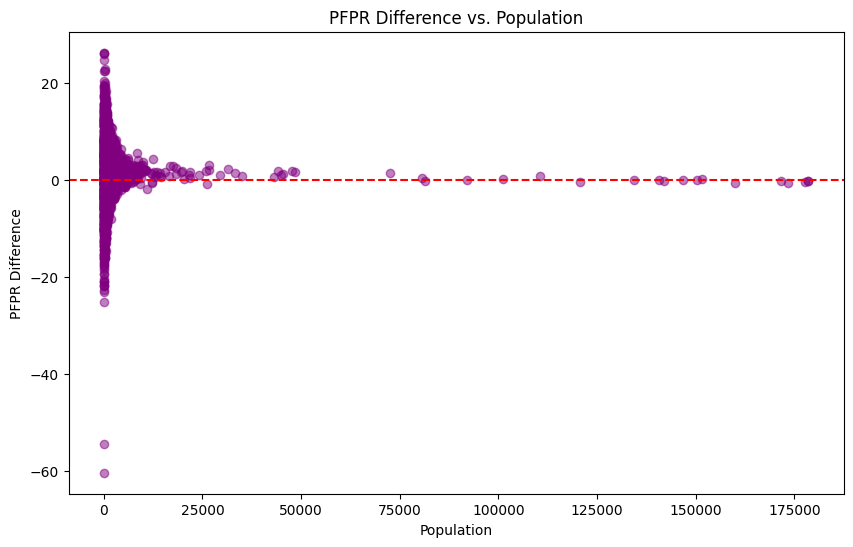

In [74]:
# Pfpr prediction error vs population
plt.figure(figsize=(10, 6))
plt.scatter(pfpr_comparison_df["population_x"], pfpr_comparison_df["pfpr_diff"], alpha=0.5, color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Population")
plt.ylabel("PFPR Difference")
plt.title("PFPR Difference vs. Population")
plt.show()

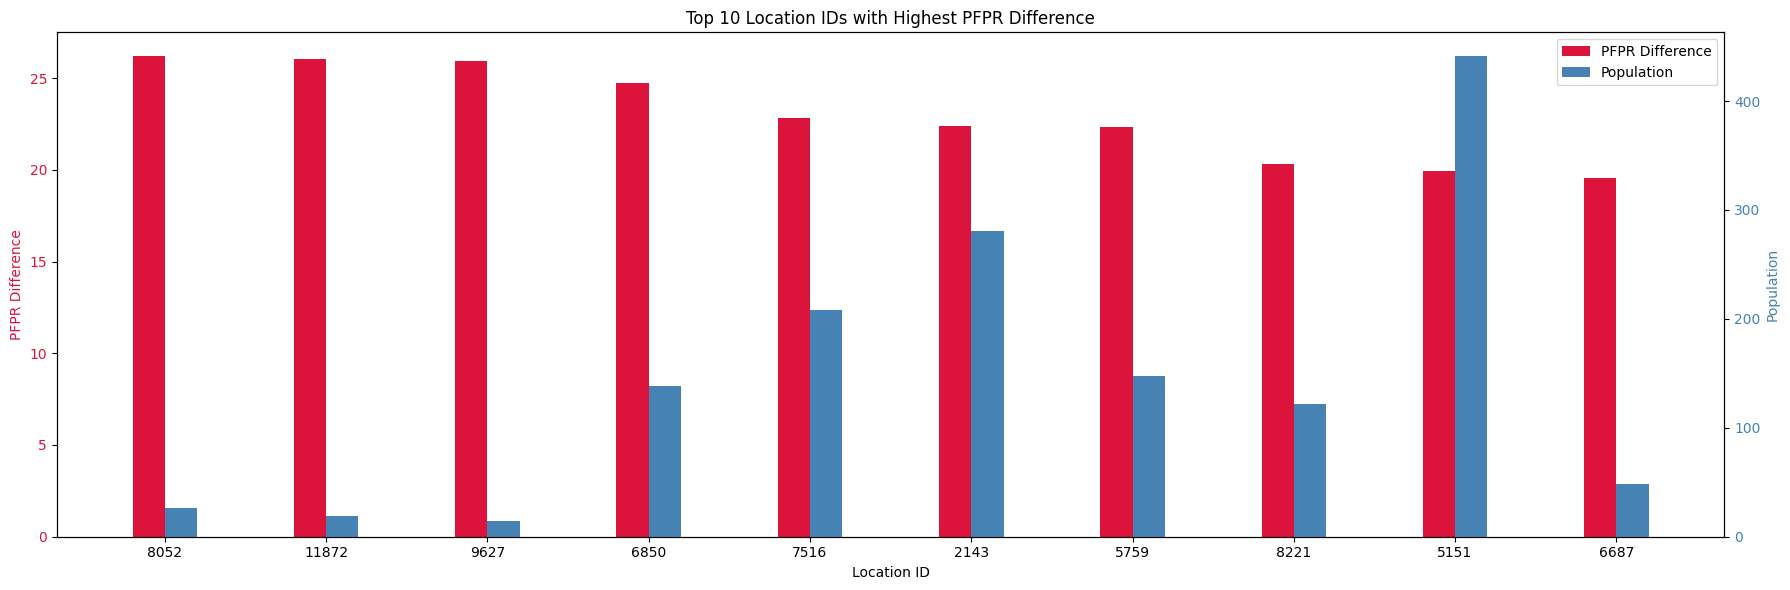

In [75]:
# Sort the dataframe by pfpr_diff in descending order and select top n
n = 10
top_n_error_df = pfpr_comparison_df.nlargest(n, "pfpr_diff")

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_n_error_df))
r2 = [x + bar_width for x in r1]

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot pfpr_diff on the primary y-axis
color = "crimson"
ax1.set_xlabel("Location ID")
ax1.set_ylabel("PFPR Difference", color=color)
ax1.bar(r1, top_n_error_df["pfpr_diff"], color=color, width=bar_width, label="PFPR Difference")
ax1.tick_params(axis="y", labelcolor=color)

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot population_x on the secondary y-axis
color = "steelblue"
ax2.set_ylabel("Population", color=color)
ax2.bar(r2, top_n_error_df["population_x"], color=color, width=bar_width, label="Population")
ax2.tick_params(axis="y", labelcolor=color)

# Add title and legend
plt.title(f"Top {n} Location IDs with Highest PFPR Difference")
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Set x-axis ticks and labels
plt.xticks(
    [r + bar_width / 2 for r in range(len(top_n_error_df))], top_n_error_df["locationid"].astype(str), rotation=90
)
plt.show()

### Adjusting beta map

In [76]:
# Create a new beta map raster after adjusting beta values

# def update_rule(beta, k):
#     beta = beta + k * error
district_scaling_map = {}
for i, row in pfpr_district_comparison_df.iterrows():
    district_scaling_map[row["locationid"]] = row["pfpr2to10_x"] / row["pfpr2to10_y"]
district_scaling_map

{6: 1.1118007345432595,
 13: 1.0996996426643375,
 12: 1.0639926450922375,
 3: 1.0373977817774078,
 5: 1.0869152683844987,
 4: 1.058104433737158,
 11: 1.088190022503593,
 2: 1.0828187020869249,
 8: 1.1010898914011624,
 10: 1.057305078860755,
 7: 1.072946891895091,
 1: 1.070522689033413,
 9: 1.0742493702754783}

In [44]:
def apply_scaling_to_beta_map(beta_raster_path, district_raster_path, scaling_map, output_path):
    """
    Applies district-specific scaling factors to the beta map.

    Parameters:
        beta_raster_path (str): Path to the input beta raster file.
        district_raster_path (str): Path to the district raster file.
        scaling_map (dict): Mapping of district IDs to scaling factors.
        output_path (str): Path to save the updated beta raster.
    """
    with rasterio.open(beta_raster_path) as beta_src, rasterio.open(district_raster_path) as district_src:
        beta = beta_src.read(1).astype(np.float32)  # Read beta raster as a float32 array
        district = district_src.read(1)  # Read district raster as an integer array

        # Preserve the NODATA value
        nodata_value = beta_src.nodata if beta_src.nodata is not None else -9999.0
        new_beta = np.copy(beta)

        for district_id, scale_factor in scaling_map.items():
            mask = (district == district_id) & (beta != nodata_value)
            new_beta[mask] *= scale_factor

        # Ensure NODATA values remain unchanged
        new_beta[beta == nodata_value] = nodata_value

        # Save the modified beta map
        with rasterio.open(
            output_path,
            "w",
            driver=beta_src.driver,
            height=beta_src.height,
            width=beta_src.width,
            count=1,
            dtype=np.float32,  # Ensure consistency
            crs=beta_src.crs,
            transform=beta_src.transform,
            nodata=nodata_value,  # Explicitly set NODATA value
        ) as dst:
            dst.write(new_beta, 1)

    print(f"Updated beta map saved to {output_path}")

In [45]:
# Running following code creates a new beta map with scaled beta values
apply_scaling_to_beta_map("beta.asc", "bfa_districts.asc", district_scaling_map, "beta_new.asc")

Updated beta map saved to beta_new.asc


## Incidence Data

In [77]:
def get_incidence_df(district_db_file, year):
    incidence_data_district_year = load_data(district_db_file, "clinicalepisodes", year)
    incidence_data_district_year_grouped = (
        incidence_data_district_year.groupby("locationid")
        .agg({"clinicalepisodes": "sum", "population": "mean"})
        .reset_index()
    )
    incidence_rate_country = (
        sum(incidence_data_district_year_grouped["clinicalepisodes"])
        / sum(incidence_data_district_year_grouped["population"])
        * 1000
    )

    print(
        f"Incidence rate (per thousand people) per year (entire country) in the year {year} : {incidence_rate_country}"
    )
    incidence_rate_district_df = incidence_data_district_year_grouped[["locationid", "clinicalepisodes", "population"]]
    incidence_rate_district_df["incidence_rate"] = (
        incidence_rate_district_df["clinicalepisodes"] / incidence_rate_district_df["population"] * 1000
    )
    return incidence_rate_district_df, incidence_rate_country

Incidence rate (per thousand people) per year (entire country) in the year 2016 : 522.039361721304
Incidence rate (per thousand people) per year (entire country) in the year 2017 : 581.6997862140022
Incidence rate (per thousand people) per year (entire country) in the year 2018 : 583.5151443117652
Incidence rate (per thousand people) per year (entire country) in the year 2019 : 584.6468037160947
Incidence rate (per thousand people) per year (entire country) in the year 2020 : 586.4377658439786
Incidence rate (per thousand people) per year (entire country) in the year 2021 : 584.2298465060236
Incidence rate (per thousand people) per year (entire country) in the year 2022 : 584.9888684593606


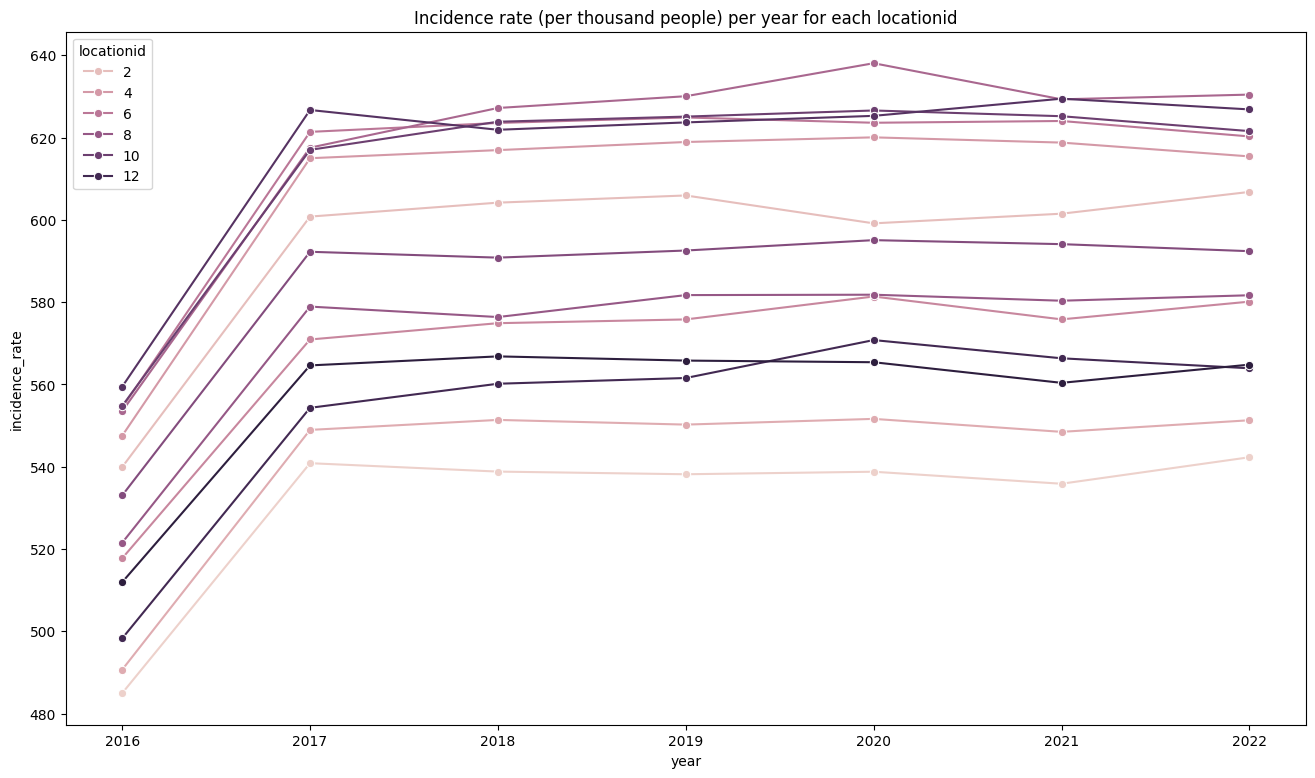

In [78]:
# district_db_file = "monthly_data_0.db" # old beta
district_db_file = "monthly_data_3.db"  # updated beta
district_db_file = "monthly_data_5.db"  # updated beta
district_db_file = "monthly_data_9.db"
incidence_rate_district_all_df = pd.DataFrame()
incidence_rate_country_all = []
years = [str(year) for year in range(2016, 2023)]
for year in years:
    incidence_rate_district_df, incidence_rate_country = get_incidence_df(district_db_file, year)
    incidence_rate_district_df["year"] = year
    incidence_rate_district_all_df = pd.concat(
        [incidence_rate_district_all_df, incidence_rate_district_df], axis=0, ignore_index=True
    )
    incidence_rate_country_all.append(incidence_rate_country)

incidence_rate_district_all_df

# create time-series plot of incidence rate for each locationid
plt.figure(figsize=(16, 9))
sns.lineplot(data=incidence_rate_district_all_df, x="year", y="incidence_rate", hue="locationid", marker="o")
plt.title("Incidence rate (per thousand people) per year for each locationid")
plt.show()

## MISC

### Narrowing Down search space for beta values

min beta:  0.028436877151027766  max beta:  0.6177430729549387
min beta:  0.033711545169353485  max beta:  0.8538841009140015
min beta:  0.03366430476307869  max beta:  0.9405382871627808


(array([3.600e+02, 3.376e+03, 5.435e+03, 1.969e+03, 5.960e+02, 1.380e+02,
        3.400e+01, 6.000e+00, 7.000e+00, 4.000e+00]),
 array([0.0336643 , 0.1243517 , 0.2150391 , 0.3057265 , 0.3964139 ,
        0.4871013 , 0.57778869, 0.66847609, 0.75916349, 0.84985089,
        0.94053829]),
 <BarContainer object of 10 artists>)

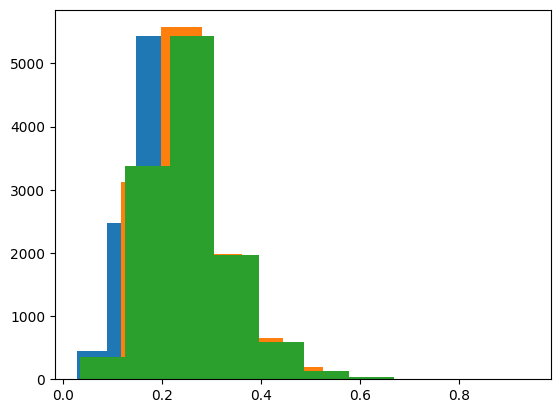

In [51]:
fig, ax = plt.subplots()
metadata, coordinates_to_location_map, raster_data = read_raster_data(".", "beta1.asc")
betas = raster_data.values()
print("min beta: ", min(betas), " max beta: ", max(betas))
plt.hist(betas)

metadata, coordinates_to_location_map, raster_data = read_raster_data(".", "beta2.asc")
betas = raster_data.values()
print("min beta: ", min(betas), " max beta: ", max(betas))
plt.hist(betas)

metadata, coordinates_to_location_map, raster_data = read_raster_data(".", "beta3.asc")
betas = raster_data.values()
print("min beta: ", min(betas), " max beta: ", max(betas))
plt.hist(betas)

### Exploring seasonality adjustment

Text(0, 0.5, 'Adjustment')

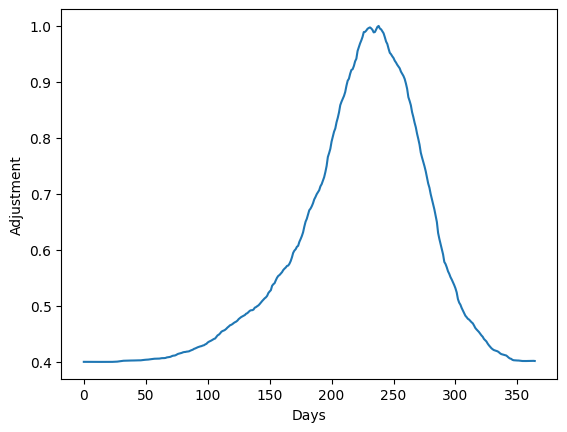

In [52]:
adjustment_df = pd.read_csv("bfa_adjustment.csv", header=None)
adjustment_df.rename(columns={0: "adjustment"}, inplace=True)
plt.plot(adjustment_df.index, adjustment_df.adjustment)
plt.xlabel("Days")
plt.ylabel("Adjustment")